In [1]:
# Import packages

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_mccd_psf_field as tf_mccd_psf_field
import wf_psf.tf_psf_field as tf_psf_field
import wf_psf.metrics as wf_metrics
import wf_psf.train_utils as wf_train_utils

import poppy as poppy

# Plot style & colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


In [2]:
args = {
    'dataset_folder': '/disk/xray0/tl3/repos/wf-studies/WFE_res/dataset/',
    #'dataset_folder': '/Users/ec270266/Desktop/Stage-CEA/output/more_stars/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_009_wfeRes_4096.npy',
    #'train_dataset_file': 'train_Euclid_res_3000_TrainStars_id_008_wfeRes_128.npy',
    'test_dataset_file': 'test_Euclid_res_id_009_wfeRes_4096.npy',
    #'test_dataset_file': 'test_Euclid_res_id_008_wfeRes_128.npy',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    #'pupil_diameter': 128,
    'n_bins_lda':20,
    #'n_bins_lda':8,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
    'chkp_save_path':'/disk/xray0/tl3/repos/wf-studies/WFE_res/wf-outputs/chkp/chkp_callback_poly_wfe_study_id009_256_benchmark_bis_1_cycle2',
    #'chkp_save_path':'../../more_stars/wf-outputs/chkp/3000_stars/chkp_callback_poly_full_poly_3000_stars_cycle2',
}

In [3]:
## Prepare the inputs
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(
    n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it, :, :] = zernikes[it]
np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)
print('Zernike cube:')
print(tf_zernike_cube.shape)

# Generate ground truth Zernike maps
zernikes_gt = wf_utils.zernike_generator(
    n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter']
)
# Now as cubes
np_zernike_cube_gt = np.zeros((len(zernikes_gt), zernikes_gt[0].shape[0], zernikes_gt[0].shape[1]))
for it in range(len(zernikes_gt)):
    np_zernike_cube_gt[it, :, :] = zernikes_gt[it]
np_zernike_cube_gt[np.isnan(np_zernike_cube_gt)] = 0
tf_zernike_cube_gt = tf.convert_to_tensor(np_zernike_cube_gt, dtype=tf.float32)
print('Ground truth Zernike cube:')
print(tf_zernike_cube_gt.shape)

Zernike cube:
(15, 256, 256)
Ground truth Zernike cube:
(45, 256, 256)


2023-06-03 21:12:22.662647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 21:12:23.135979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 709 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [4]:
## Generate initializations
# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)
# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

In [5]:
obscurations.shape

(256, 256)

## Original code

In [6]:
def arbitrary_basis(aperture, nterms=15, rho=None, theta=None, outside=np.nan):
    """ Orthonormal basis on arbitrary aperture, via Gram-Schmidt

    Return a cube of Zernike-like terms from 1 to N, calculated on an
    arbitrary aperture, each as a 2D array showing the value at each
    point. (Regions outside the unit circle on which the Zernike is
    defined are initialized to zero.)

    This implements Gram-Schmidt orthonormalization numerically,
    starting from the regular Zernikes, to generate an orthonormal basis
    on some other aperture

    Parameters
    -----------
    aperture : 2D array_like
        2D array representing the arbitrary aperture.
        All positive nonzero values are considered within the aperture;
        any pixels with zero, negative, or NaN values will be considered
        outside the aperture, and set equal to the 'outside' parameter value.
    nterms : int, optional
        Number of Zernike terms to return, starting from piston.
        (e.g. ``nterms=1`` would return only the Zernike piston term.)
        Default is 15.
    rho, theta : array_like, optional
        Image plane coordinates. `rho` should be 0 at the origin
        and 1.0 at the edge of the pupil. `theta` should be
        the angle in radians.
    outside : float
        Value for pixels outside the specified aperture.
        Default is `np.nan`, but you may also find it useful for this to
        be 0.0 sometimes.
    """
    # code submitted by Arthur Vigan - see https://github.com/mperrin/poppy/issues/166

    shape = aperture.shape
    assert len(shape) == 2 and shape[0] == shape[1], \
        "only square aperture arrays are supported"

    # any pixels with zero or NaN in the aperture are outside the area
    apmask = (np.isfinite(aperture) & (aperture > 0))
    apmask_float = np.asarray(apmask, float)
    A = apmask.sum()

    if theta is None and rho is None:
        # To avoid clipping the aperture, we precompute the zernike modes
        # on an array oversized s.t. the zernike disk circumscribes the
        # entire aperture. We then slice the zernike array down to the
        # requested array size and cut the aperture out of it.

        # get max extent of aperture from array center
        yind, xind = np.where(apmask)
        distance = np.sqrt((yind - (shape[0] - 1) / 2.) ** 2 + (xind - (shape[1] - 1) / 2.) ** 2)
        max_extent = distance.max()

        # calculate padding for oversizing zernike_basis
        ceil = lambda x: np.ceil(x) if x > 0 else 0  # avoid negative values
        padding = (int(ceil((max_extent - (shape[0] - 1) / 2.))),
                   int(ceil((max_extent - (shape[1] - 1) / 2.))))
        padded_shape = (shape[0] + padding[0] * 2, shape[1] + padding[1] * 2)
        npix = padded_shape[0]

        # precompute zernikes on oversized array
        Z = np.zeros((nterms + 1,) + padded_shape)
        Z[1:] = poppy.zernike.zernike_basis(nterms=nterms, npix=npix, rho=rho, theta=theta, outside=0.0)
        # slice down to original aperture array size
        Z = Z[:, padding[0]:padded_shape[0] - padding[0],
              padding[1]:padded_shape[1] - padding[1]]
    else:
        # precompute zernikes on user-defined rho, theta
        Z = np.zeros((nterms + 1,) + shape)
        Z[1:] = poppy.zernike.zernike_basis(nterms=nterms, rho=rho, theta=theta, outside=0.0)

    G = [np.zeros(shape), np.ones(shape)]  # array of G_i etc. intermediate fn
    H = [np.zeros(shape), apmask_float.copy()]  # array of zernikes on arbitrary basis
    c = {}  # coefficients hash

    for j in np.arange(nterms - 1) + 1:  # can do one less since we already have the piston term
        # _log.debug("  j = " + str(j))
        # Compute the j'th G, then H
        nextG = Z[j + 1] * apmask_float
        for k in np.arange(j) + 1:
            c[(j + 1, k)] = -1 / A * (Z[j + 1] * H[k] * apmask_float).sum()
            if c[(j + 1, k)] != 0:
                nextG += c[(j + 1, k)] * H[k]
            # _log.debug("    c[%s] = %f", str((j + 1, k)), c[(j + 1, k)])

        nextH = nextG / np.sqrt((nextG ** 2).sum() / A)

        G.append(nextG)
        H.append(nextH)

        # TODO - contemplate whether the above algorithm is numerically stable
        # cf. modified gram-schmidt algorithm discussion on wikipedia.

    basis = np.asarray(H[1:])  # drop the 0th null element
    basis[:, ~apmask] = outside

    return basis



In [12]:

theta = None
rho = None
aperture = obscurations
nterms = 15
outside=np.nan

shape = aperture.shape
assert len(shape) == 2 and shape[0] == shape[1], \
    "only square aperture arrays are supported"

# any pixels with zero or NaN in the aperture are outside the area
apmask = (np.isfinite(aperture) & (aperture > 0))
apmask_float = np.asarray(apmask, float)
A = apmask.sum()

if theta is None and rho is None:
    # To avoid clipping the aperture, we precompute the zernike modes
    # on an array oversized s.t. the zernike disk circumscribes the
    # entire aperture. We then slice the zernike array down to the
    # requested array size and cut the aperture out of it.

    # get max extent of aperture from array center
    yind, xind = np.where(apmask)
    distance = np.sqrt((yind - (shape[0] - 1) / 2.) ** 2 + (xind - (shape[1] - 1) / 2.) ** 2)
    max_extent = distance.max()

    # calculate padding for oversizing zernike_basis
    ceil = lambda x: np.ceil(x) if x > 0 else 0  # avoid negative values
    padding = (int(ceil((max_extent - (shape[0] - 1) / 2.))),
                int(ceil((max_extent - (shape[1] - 1) / 2.))))
    padded_shape = (shape[0] + padding[0] * 2, shape[1] + padding[1] * 2)
    npix = padded_shape[0]

    # precompute zernikes on oversized array
    Z = np.zeros((nterms + 1,) + padded_shape)
    Z[1:] = poppy.zernike.zernike_basis(nterms=nterms, npix=npix, rho=rho, theta=theta, outside=0.0)
    # slice down to original aperture array size
    Z = Z[:, padding[0]:padded_shape[0] - padding[0],
            padding[1]:padded_shape[1] - padding[1]]

In [7]:


zk_basis = arbitrary_basis(aperture=obscurations, nterms=15, rho=None, theta=None, outside=np.nan)


In [17]:
zk_basis.shape

(15, 256, 256)

In [28]:
n_pix_Z = wf_utils.PI_zernikes(np.nan_to_num(Z[1,:,:], copy=True, nan=0.0), np.nan_to_num(Z[1,:,:], copy=True, nan=0.0), 1)

n_pix_Z_obsc = wf_utils.PI_zernikes(np.nan_to_num(zk_basis[0,:,:], copy=True, nan=0.0), np.nan_to_num(zk_basis[0,:,:], copy=True, nan=0.0), 1)


print('n_pix_zernike: ', n_pix_Z)

for it in range(zk_basis.shape[0]-1):

    # ip_Zk = wf_utils.PI_zernikes(np.nan_to_num(zk_basis[it,:,:], copy=True, nan=0.0), np.nan_to_num(zk_basis[it+1,:,:], copy=True, nan=0.0), n_pix_Z_obsc)
    ip_Zk = wf_utils.PI_zernikes(np.nan_to_num(Z[it+1,:,:], copy=True, nan=0.0), np.nan_to_num(Z[it+1,:,:], copy=True, nan=0.0), n_pix_Z)

    print('it: {:d}, IP: {:f}'.format(it, ip_Zk))


n_pix_zernike:  52536.0
it: 0, IP: 0.000000
it: 1, IP: -0.000000
it: 2, IP: 0.000000
it: 3, IP: -0.000000
it: 4, IP: 0.000000
it: 5, IP: 0.000000
it: 6, IP: 0.000000
it: 7, IP: 0.000000
it: 8, IP: 0.000000
it: 9, IP: 0.000000
it: 10, IP: -0.000000
it: 11, IP: -0.000000
it: 12, IP: 0.000000
it: 13, IP: 0.000000


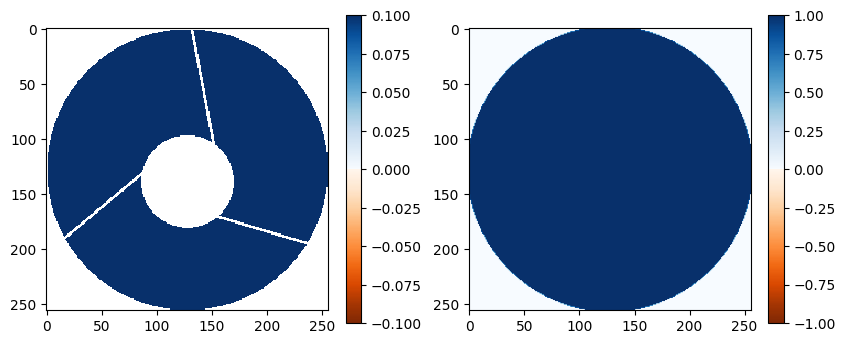

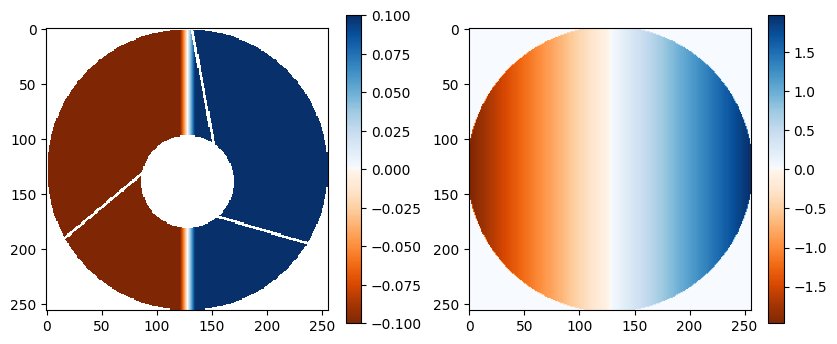

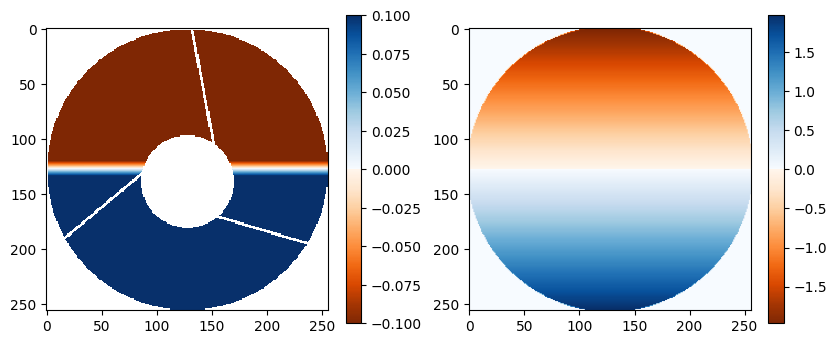

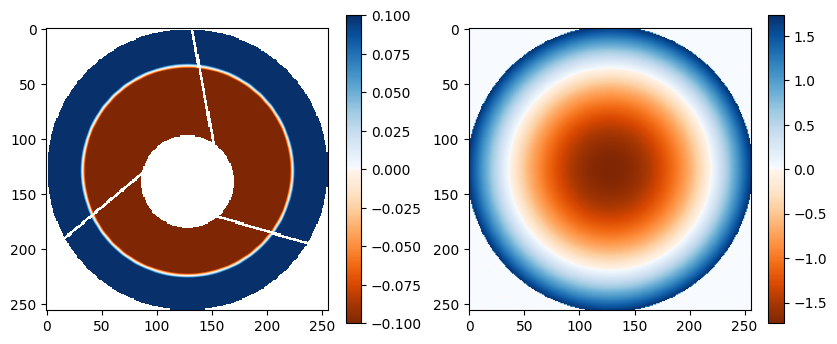

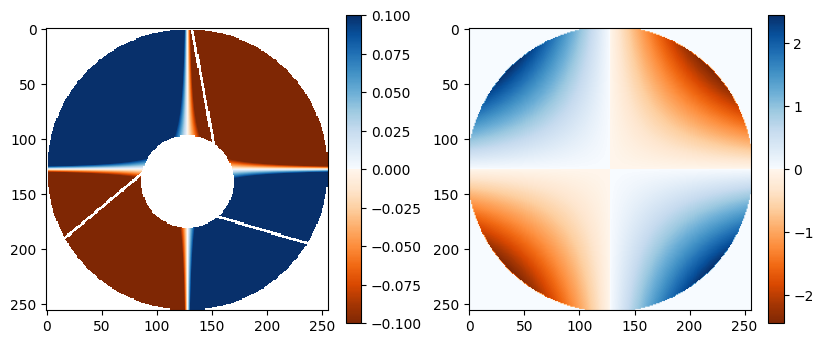

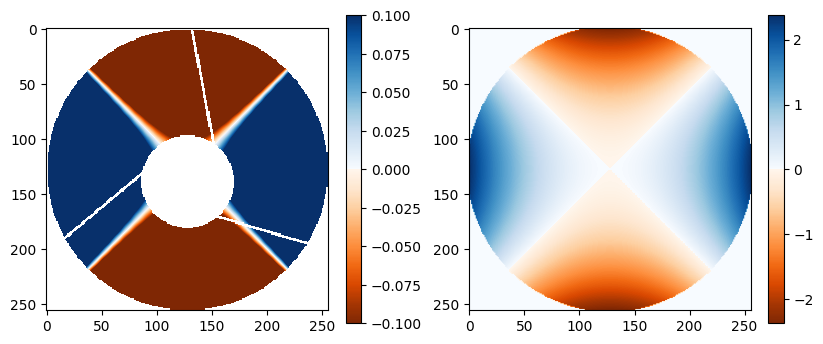

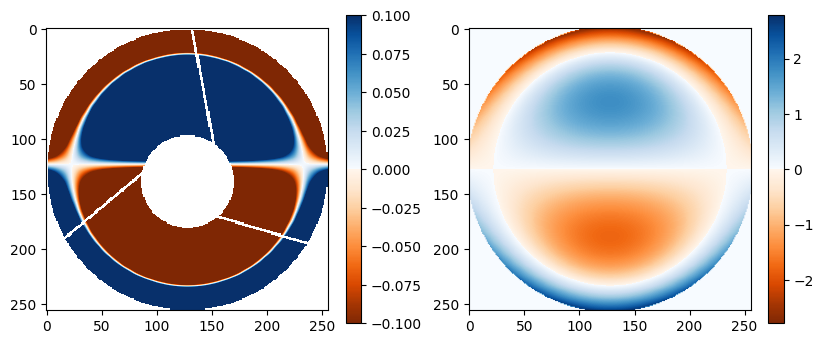

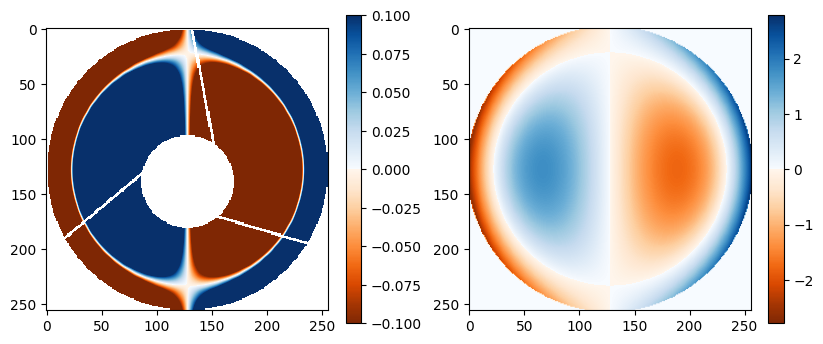

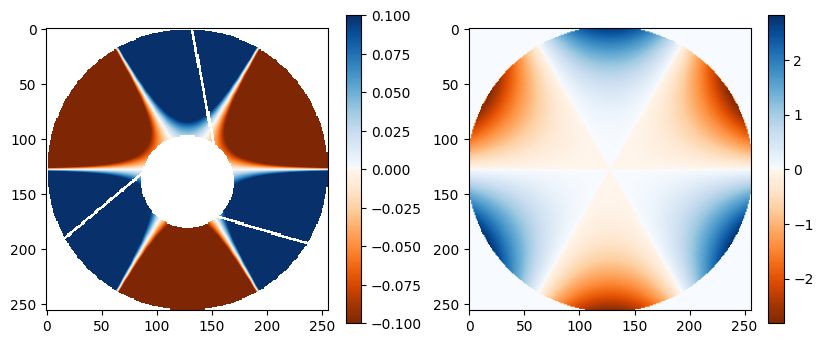

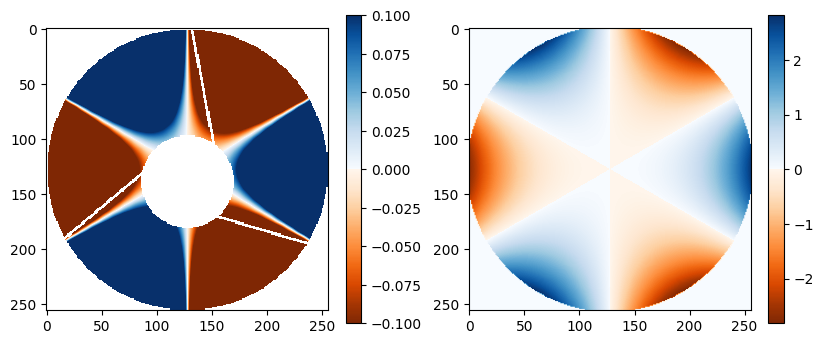

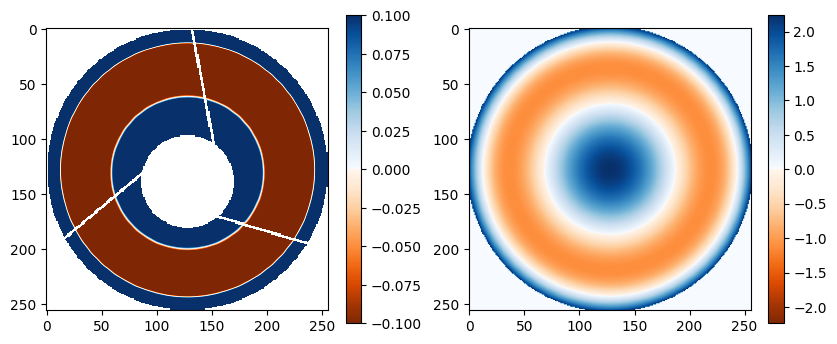

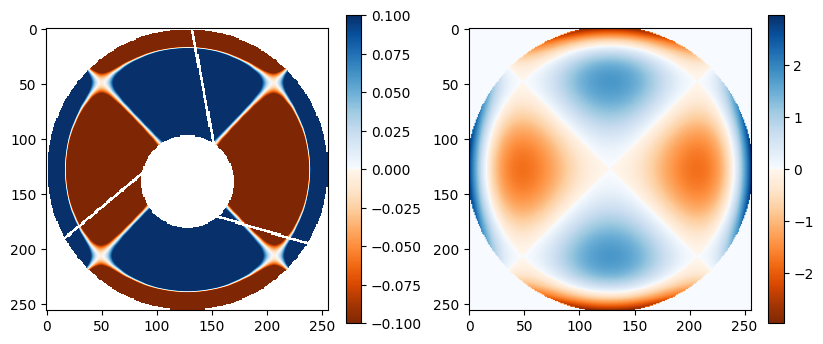

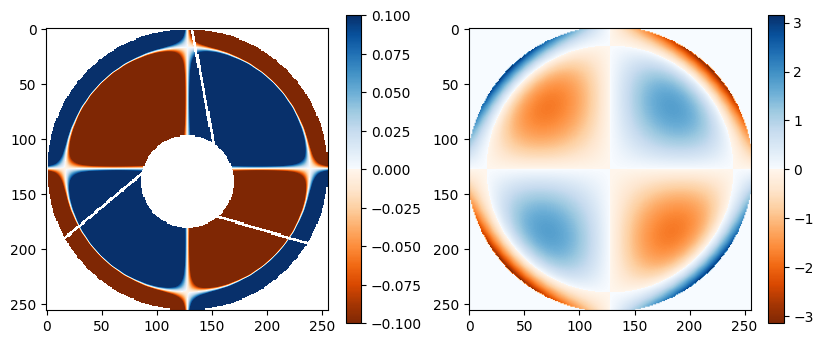

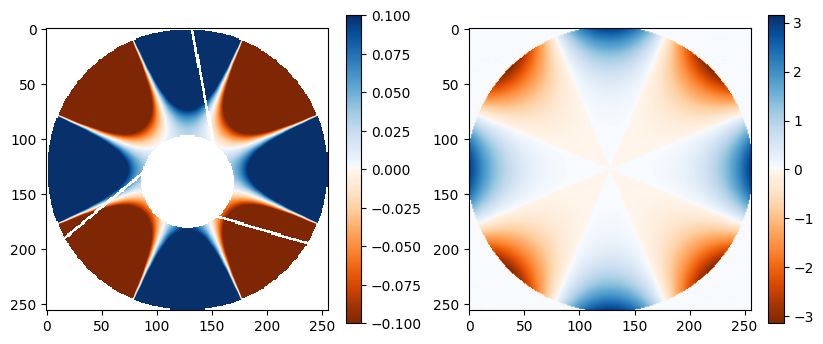

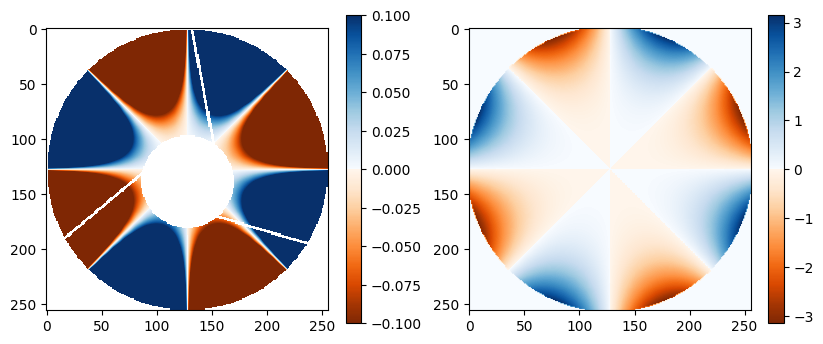

In [19]:


for it in range(zk_basis.shape[0]):
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    vmax = np.max(np.abs(zk_basis[it,:,:]))
    plt.imshow(zk_basis[it,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.colorbar()
    plt.subplot(122)
    vmax = np.max(np.abs(Z[it+1,:,:]))
    plt.imshow(Z[it+1,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.colorbar()
    plt.show()


    


In [134]:
def decompose_opd_nonorthonormal_basis(
        opd, aperture=None,
        nterms=15,
        basis_set=None,
        basis=poppy.zernike.zernike_basis_faster,
        iterations=5,
        verbose=False,
        **kwargs
):
    """ Modified version of decompose_opd, for cases where the basis function is
    *not* orthonormal, for instance using the regular Zernike functions on
    obscured apertures.

    This version subtracts off each term as it is fit, to avoid over-fitting the
    same WFE multiple times. It also iterates the fitting multiple times by re-fitting
    the residuals, in order to allow for capturing any WFE which is missed by the
    first pass at fitting.

    Based on various empirical experimentation for what is necessary to get
    reasonable behavior in this non-ideal case. Factors to consider:

    1) Masking to use just pixels good in both the zernike unit circle and the
       asymmetric numerical aperture

    2) Subtracting off the fit terms as you go, so as to not fit the same WFE
       multiple times

    3) Iterating multiples by re-fitting the residual, to include as much WFE
       as possible.

    Parameters
    -----------
    opd : 2d ndarray
        the OPD you want to fit
    aperture : 2D numpy array, optional
        Aperture mask for which pixels are included within the aperture.
        All positive nonzero values are considered within the aperture;
        any pixels with zero, negative, or NaN values will be considered
        outside the aperture, and set equal to the 'outside' parameter value.
        If this parameter is not set, the aperture will be inferred from
        the finite (i.e. non-NaN) pixels in the OPD array.
    nterms : int
        number of terms to fit
    basis : function
        which basis function to use. Defaults to Zernike
    iterations : int
        Number of iterations for convergence. Default is 5

    """

    if aperture is None:
        # _log.warning("No aperture supplied - "
        #           "using the finite (non-NaN) part of the OPD map as a guess.")
        aperture = np.isfinite(opd)

    # any pixels with zero or NaN in the aperture are outside the area
    apmask = (np.isfinite(aperture) & (aperture > 0))

    # Determine if this basis function accepts an 'aperture' parameter or not
    # If so, append that into the function's kwargs. This check is needed to
    # handle e.g. both the zernike_basis function (which doesn't accept aperture)
    # and hexike_basis or arbitrary_basis (which do).
    # if 'aperture' in inspect.signature(basis).parameters:
    kwargs['aperture'] = aperture

    if basis_set is None:
        basis_set = basis(
            nterms=nterms,
            npix=opd.shape[0],
            outside=np.nan,
            **kwargs
        )
    else:
        basis_set_copy = np.nan_to_num(basis_set, copy=True, nan=0.0)

    wgood = (apmask & np.isfinite(basis_set[1]))
    ngood = apmask.sum()

    coeffs = np.zeros(nterms)
    # opd_copy = np.copy(opd)
    opd_copy = np.nan_to_num(obscurations, copy=True, nan=0.0)

    # for i, b in enumerate(basis_set):
    #     this_coeff = (opd_copy * b)[wgood].sum() / ngood
    #     coeffs[i] += this_coeff

    # for i, b in enumerate(basis_set):   
    #     opd_copy -= coeffs[i] * b

    # for count in range(iterations):
    #     for i, b in enumerate(basis_set):
    #         this_coeff = (opd_copy * b)[wgood].sum() / ngood
    #         coeffs[i] += this_coeff

    #     for i, b in enumerate(basis_set):   
    #         opd_copy -= coeffs[i] * b

    for count in range(iterations):
        for i, b in enumerate(basis_set_copy):
            # this_coeff = (opd_copy * b)[wgood].sum() / ngood
            this_coeff = (opd_copy * b).sum() / ngood
            opd_copy -= this_coeff * b
            coeffs[i] += this_coeff
        if verbose:
            print("Iteration {}/{}: {}".format(count, iterations, coeffs))

    return coeffs


In [180]:


def my_decompose_opd_nonorthonormal_basis(opd, obscurations, zk_basis, iters):
    opd_zeros = np.nan_to_num(opd, copy=True, nan=0.0)
    obscurations_zeros = np.nan_to_num(obscurations, copy=True, nan=0.0)
    ngood = obscurations.sum()

    zk_basis_zeros = np.nan_to_num(zk_basis, copy=True, nan=0.0)

    obsc_coeffs = np.zeros(zk_basis_zeros.shape[0])
    new_coeffs = np.zeros(zk_basis_zeros.shape[0])

    # obsc_coeffs = np.array([(opd_zeros * b).sum() / ngood
    #         for b in zk_basis_zeros])
    
    # for i, b in enumerate(zk_basis_zeros):   
    #     opd_zeros -= (obsc_coeffs[i] * b) * obscurations_zeros

    for count in range(iters):
        for i, b in enumerate(zk_basis_zeros):
            this_coeff = (opd_zeros * b).sum() / ngood
            new_coeffs[i] = this_coeff

        for i, b in enumerate(zk_basis_zeros):
            opd_zeros -= (new_coeffs[i] * b) * obscurations_zeros

        obsc_coeffs += new_coeffs
        new_coeffs = np.zeros(zk_basis_zeros.shape[0])

    # for count in range(iters):
    #     for i, b in enumerate(zk_basis_zeros):
    #         this_coeff = (opd_zeros * b).sum() / ngood
    #         opd_zeros -= (obsc_coeffs[i] * b) #* obscurations_zeros
    #         obsc_coeffs[i] += this_coeff
        
    #     print("Iteration {}/{}: {}".format(count, iters, obsc_coeffs))

    return obsc_coeffs


In [181]:
nterms = 66

zk_basis = arbitrary_basis(aperture=obscurations, nterms=nterms, rho=None, theta=None, outside=np.nan)


In [182]:
# gt_coeffs = np.zeros((15))
# gt_coeffs[3] = 1.
# gt_coeffs[5] = 0.5
# gt_coeffs[12] = -0.75
# gt_coeffs[14] = 0.25

gt_coeffs = np.random.randn(nterms)


In [183]:


opd = 0.

for it in range(zk_basis.shape[0]):
    opd += zk_basis[it,:,:] * gt_coeffs[it]

opd_obsc = np.copy(opd) * obscurations


opd_zeros = np.nan_to_num(opd, copy=True, nan=0.0)
ngood = obscurations.sum()

no_obsc_coeffs = np.array([(opd_zeros * b).sum() / ngood
            for b in np.nan_to_num(zk_basis, copy=True, nan=0.0)])

opd_obsc_zeros = np.nan_to_num(opd_obsc, copy=True, nan=0.0)
obsc_coeffs = np.array([(opd_obsc_zeros * b).sum() / ngood
            for b in np.nan_to_num(zk_basis, copy=True, nan=0.0)])

# coeffs = np.array(decompose_opd_nonorthonormal_basis(
#     opd_obsc, aperture=obscurations, nterms=15, basis=poppy.zernike.zernike_basis, basis_set=zk_basis,
#     iterations=1, verbose=False
# ))

coeffs = my_decompose_opd_nonorthonormal_basis(opd_obsc, obscurations, zk_basis, iters=50)

print(gt_coeffs)
print(coeffs)
print(no_obsc_coeffs)
print(obsc_coeffs)

[ 1.63134965 -0.69425582 -2.15748856  0.36901192  0.8923496  -0.99404761
  0.12115779  0.45580802 -0.52245517 -2.06347983 -1.71563493  1.2727174
  0.27058957 -1.28266231 -1.60871937  0.25068    -0.67551279  1.97957773
 -2.05318966  1.04286136  0.59142151  2.20196758 -0.05902137  0.0941613
  0.44676879 -1.15556512 -0.44009963  0.04794034  0.89302332 -0.76221384
 -1.02788873 -0.42172126  1.14852752 -0.56153164 -1.13947821 -1.56623917
  0.43487441  0.17820453  0.34927045 -0.38888459 -0.66899939 -1.48760647
  0.42561485  1.50478039  0.55394622 -1.54024397  1.03405735  0.29769354
 -1.08352209  1.65444028  0.39820343 -1.5066032   0.57853015 -1.31470473
 -1.96299864  0.26335378 -0.24625082  0.67998762  0.68150614 -0.39155184
  0.79017355 -1.19867779  0.00905362  0.22295416  0.60451482  0.67360542]
[ 1.63134965 -0.69425582 -2.15748856  0.36901192  0.8923496  -0.99404761
  0.12115779  0.45580802 -0.52245517 -2.06347983 -1.71563493  1.2727174
  0.27058957 -1.28266231 -1.60871937  0.25068    -0.6

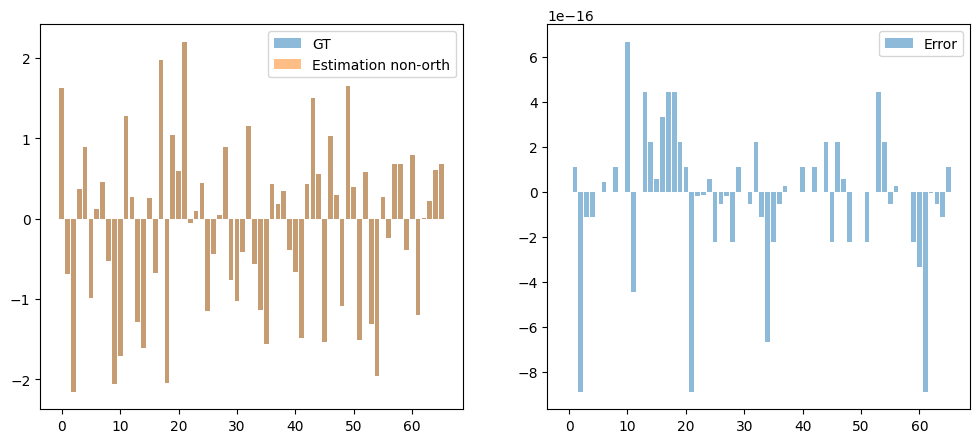

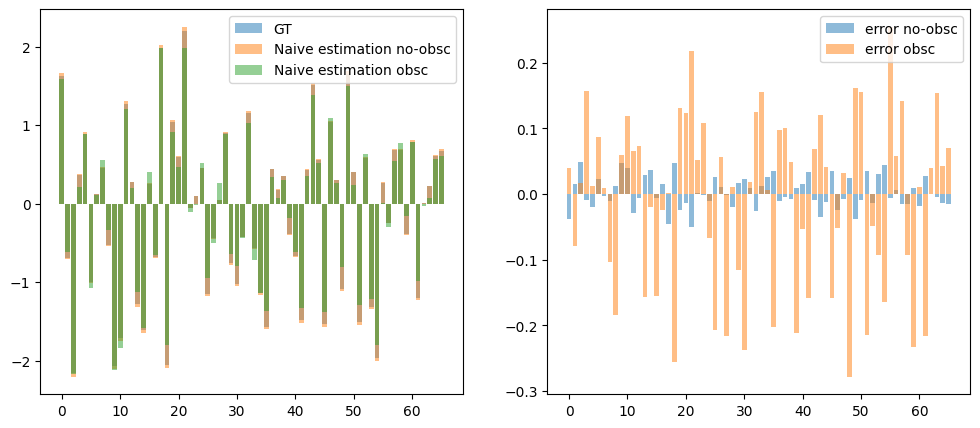

In [184]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.bar(np.array(range(len(coeffs))), gt_coeffs, alpha=0.5, label='GT')
plt.bar(np.array(range(len(coeffs))), coeffs, alpha=0.5, label='Estimation non-orth')
plt.legend()

plt.subplot(122)
plt.bar(np.array(range(len(coeffs))), gt_coeffs - coeffs, alpha=0.5, label='Error')
plt.legend()
plt.show()


plt.figure(figsize=(12,5))

plt.subplot(121)
plt.bar(np.array(range(len(coeffs))), gt_coeffs, alpha=0.5, label='GT')
plt.bar(np.array(range(len(no_obsc_coeffs))), no_obsc_coeffs, alpha=0.5, label='Naive estimation no-obsc')
plt.bar(np.array(range(len(obsc_coeffs))), obsc_coeffs, alpha=0.5, label='Naive estimation obsc')
plt.legend()

plt.subplot(122)
plt.bar(np.array(range(len(coeffs))), gt_coeffs - no_obsc_coeffs, alpha=0.5, label='error no-obsc')
plt.bar(np.array(range(len(coeffs))), gt_coeffs - obsc_coeffs, alpha=0.5, label='error obsc')
plt.legend()

plt.show()
